# Imports

In [1]:
import sys
import matplotlib.pyplot as plt

In [2]:
# sys.path.insert(1, '/kaggle/input/fifafi')
# from util import *
from Config.util import *

# Load the data

In [3]:
data = pd.read_csv('Datasets/final_data.csv')

# Creating dataset and Training

In order to avoid bias results because of randomness, we will use the train_evaluate_repeat function from utils to train the model on multiple datasets and report the average results.

We will also make a huge test set to cover most of the combinations.

In [4]:
target_col_name = 'value_eur'

In [5]:
data = standardize_features(data, target_col_name)

In [6]:
test_pairs = generate_random_pairs(data, 20000)
test_df = create_pair_df(data, test_pairs, target_col_name)

In [7]:
tree_depth = int(np.round(np.sqrt(len(data.columns))))

In [8]:
mf1 = train_evaluate_repeat(generate_random_pairs, data, num_samples=100000, depth=tree_depth, test_df=test_df, use_bradley=True, exp=False, add_noise=False, noise=0.1, label_col=target_col_name, repeats=1)

100%|██████████| 1/1 [00:59<00:00, 59.38s/it]

Mean Accuracy: 0.8689
Mean Precision: 0.8640992035487448
Mean Recall: 0.8705942102590147
Mean F1 Score: 0.8673345476624165


We can see that although we used pca to put the labels, the accuracy is great. Now this model is ready to be used as a pretrained model.

Now we check the variance of the dataset according to the PCA and determine the number of pretraining samples according to this factor.

In [9]:
len(data)

16685

In [10]:
# As there is a significant number of data points, we will down-sample
data = data.sample(n = 10000)

In [11]:
var, residuals = calculate_pca_var(data, target_col_name)
print(var)

47.93749321564516


In [12]:
# Calculating the number of pairs
max_pairs = len(data)
alpha = 1e-7

num_pairs = int(max_pairs / (1 + alpha * var))
print(num_pairs)

9999


In [13]:
data.reset_index(inplace=True, drop=True)

In [14]:
pretrain_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': tree_depth
}
pretrained_model = pretrain_model_with_residuals(df=data, n_samples=num_pairs, pretrain_params=pretrain_params, target_col=target_col_name, residuals=residuals)

In [15]:
step = 50
num_samples = 800
repeats = 40

f1_scores_UB_repeats = []
f1_scores_UP_repeats = []
f1_scores_RB_repeats = []

# Create a for loop from n to num_samples with a step of n
for _ in range(repeats):
    f1_scores_UB, f1_scores_UP, f1_scores_RB = compare_three_methods(
        df=data,
        test_df=test_df,
        pretrain_params=pretrain_params,
        pretrained_model=pretrained_model,
        target_col=target_col_name,
        use_bradley=True,
        exp=False,
        add_noise=False,
        total_pairs=num_samples,
        batch_size=step,
    )
    f1_scores_UB_repeats.append(f1_scores_UB)
    f1_scores_UP_repeats.append(f1_scores_UP)
    f1_scores_RB_repeats.append(f1_scores_RB)

save_f1_scores("./Plots/fifa_f1_repeat.pkl", f1_scores_UB_repeats, f1_scores_UP_repeats, f1_scores_RB_repeats)
# Compute the average F1 scores across repeats
average_f1_scores_UB = np.mean(f1_scores_UB_repeats, axis=0)
average_f1_scores_UP = np.mean(f1_scores_UP_repeats, axis=0)
average_f1_scores_RB = np.mean(f1_scores_RB_repeats, axis=0)

Blank model with random pairs: 100%|██████████| 16/16 [00:05<00:00,  2.84it/s]


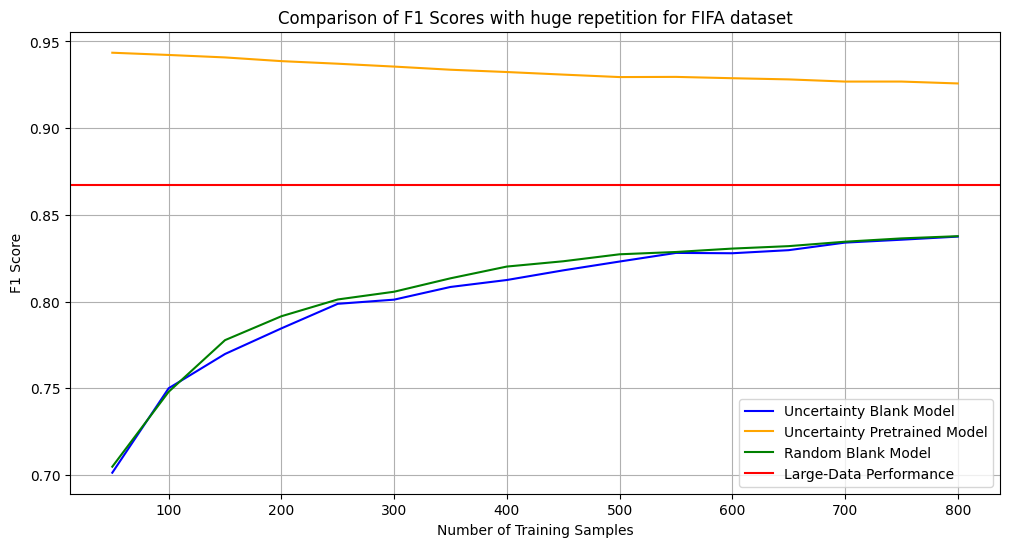

In [16]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(step, num_samples+1, step), average_f1_scores_UB, label='Uncertainty Blank Model', color='blue')
plt.plot(range(step, num_samples+1, step), average_f1_scores_UP, label='Uncertainty Pretrained Model', color='orange')
plt.plot(range(step, num_samples+1, step), average_f1_scores_RB, label='Random Blank Model', color='green')
plt.axhline(y = mf1, color = 'r', linestyle = '-', label='Large-Data Performance')
plt.xlabel('Number of Training Samples')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores with huge repetition for FIFA dataset')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
step = 50
num_samples = 10000
repeats = 1

f1_scores_UB_repeats2 = []
f1_scores_UP_repeats2 = []
f1_scores_RB_repeats2 = []

# Create a for loop from n to num_samples with a step of n
for _ in range(repeats):
    f1_scores_UB, f1_scores_UP, f1_scores_RB = compare_three_methods(
        df=data,
        test_df=test_df,
        pretrain_params=pretrain_params,
        pretrained_model=pretrained_model,
        target_col=target_col_name,
        use_bradley=True,
        exp=False,
        add_noise=False,
        total_pairs=num_samples,
        batch_size=step,
    )
    f1_scores_UB_repeats2.append(f1_scores_UB)
    f1_scores_UP_repeats2.append(f1_scores_UP)
    f1_scores_RB_repeats2.append(f1_scores_RB)

save_f1_scores("./Plots/fifa_f1_wide.pkl", f1_scores_UB_repeats2, f1_scores_UP_repeats2, f1_scores_RB_repeats2)
# Compute the average F1 scores across repeats
average_f1_scores_UB2 = np.mean(f1_scores_UB_repeats2, axis=0)
average_f1_scores_UP2 = np.mean(f1_scores_UP_repeats2, axis=0)
average_f1_scores_RB2 = np.mean(f1_scores_RB_repeats2, axis=0)

Blank model with random pairs: 100%|██████████| 200/200 [04:52<00:00,  1.46s/it]


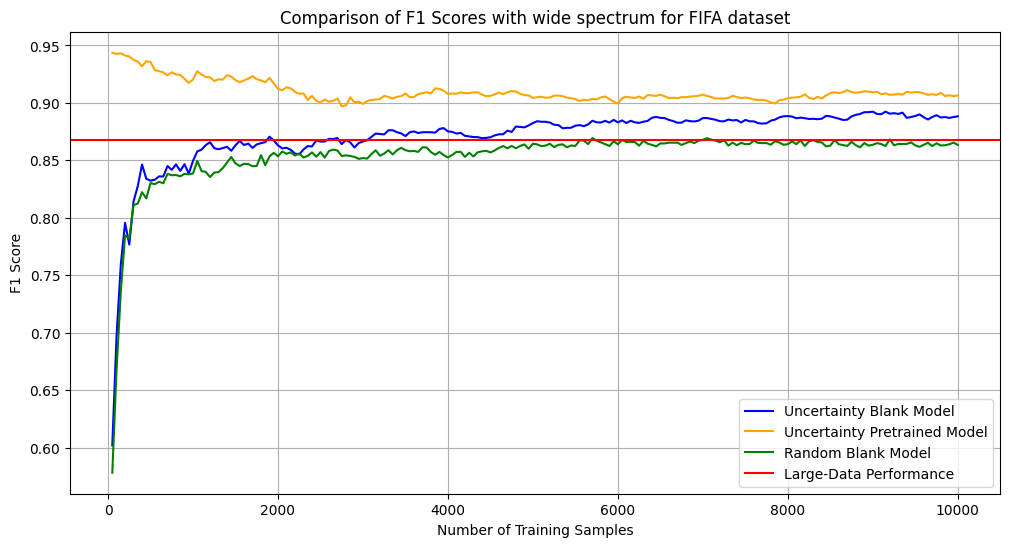

In [18]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(step, num_samples+1, step), average_f1_scores_UB2, label='Uncertainty Blank Model', color='blue')
plt.plot(range(step, num_samples+1, step), average_f1_scores_UP2, label='Uncertainty Pretrained Model', color='orange')
plt.plot(range(step, num_samples+1, step), average_f1_scores_RB2, label='Random Blank Model', color='green')
plt.axhline(y = mf1, color = 'r', linestyle = '-', label='Large-Data Performance')
plt.xlabel('Number of Training Samples')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores with wide spectrum for FIFA dataset')
plt.legend()
plt.grid(True)
plt.show()